In [1]:
import torch 
import math
import numpy as np 
import matplotlib.pyplot as plt
import timeit 
import torch.nn.functional as F
from tqdm import tqdm
import cv2

In [2]:
#!pip install sporco
#!pip install segyio
from sporco import array,plot,util
import segyio

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

**Load poststack data**

In [4]:
def mirror_padding(image, top_padding, bottom_padding, left_padding, right_padding):
    h, w = image.shape
    new_h = h + top_padding + bottom_padding
    new_w = w + left_padding + right_padding
    padded_image = np.zeros((new_h, new_w), dtype=image.dtype)
    
    padded_image[top_padding:top_padding + h, left_padding:left_padding + w] = image
    
    if top_padding > 0:
        padded_image[:top_padding, left_padding:left_padding + w] = image[:top_padding][::-1]
    
    if bottom_padding > 0:
        padded_image[top_padding + h:, left_padding:left_padding + w] = image[-bottom_padding:][::-1]
    
    if left_padding > 0:
        padded_image[top_padding:top_padding + h, :left_padding] = image[:, :left_padding][:, ::-1]
    
    if right_padding > 0:
        padded_image[top_padding:top_padding + h, left_padding + w:] = image[:, -right_padding:][:, ::-1]
    
    if top_padding > 0 and left_padding > 0:
        padded_image[:top_padding, :left_padding] = image[:top_padding, :left_padding][::-1, ::-1]
    
    if top_padding > 0 and right_padding > 0:
        padded_image[:top_padding, left_padding + w:] = image[:top_padding, -right_padding:][::-1, ::-1]
    
    if bottom_padding > 0 and left_padding > 0:
        padded_image[top_padding + h:, :left_padding] = image[-bottom_padding:, :left_padding][::-1, ::-1]
    
    if bottom_padding > 0 and right_padding > 0:
        padded_image[top_padding + h:, left_padding + w:] = image[-bottom_padding:, -right_padding:][::-1, ::-1]
    
    return padded_image
def padding(img):
    padd_img = img
    if (img.shape[0] % 128 != 0):
        pad = math.ceil(img.shape[0]/128)*128 - img.shape[0]
        if pad%2==0:
            top = int(pad/2)
            bot = int(pad/2)
        else:
            top = math.ceil(pad/2)
            bot = math.floor(pad/2)
        padd_img = mirror_padding(img,top,bot,0,0)
    if (img.shape[1] % 128 != 0):
        pad = math.ceil(img.shape[1]/128)*128 - img.shape[1]
        if pad%2==0:
            lf =int(pad/2)
            rt = int(pad/2)
        else:
            lf = math.ceil(pad/2)
            rt = math.floor(pad/2)
        padd_img = mirror_padding(padd_img,0,0,lf,rt)
    return padd_img, top, bot, lf, rt

(400, 1000)


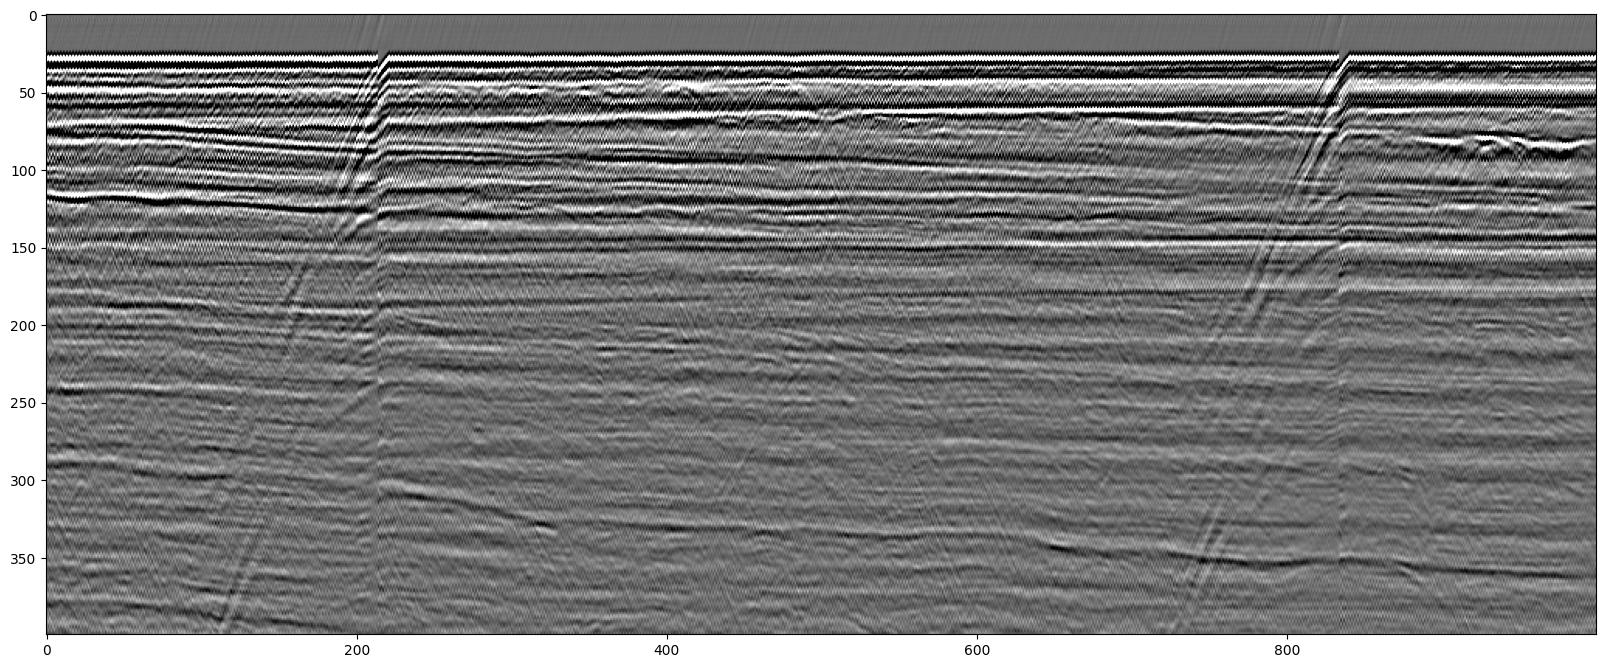

In [5]:
original = np.load('datasets/mobileAvo.npy')

original = original[:original.shape[0],:original.shape[1]]
original = (original - np.min(original))/(np.max(original) - np.min(original))

TestData, top, bot, lf, rt = padding(original)
noisi = np.random.normal(0,1,original.shape)
noisi -= noisi.min()
noisi /= noisi.max()



print(original.shape)
figsize=(20, 20)
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=figsize, facecolor='w', edgecolor='k',
                       squeeze=False,
                       sharex=True)
axs = axs.ravel()
im = axs[0].imshow(original, cmap="gray", vmin=0.35, vmax=0.7)

**Data patch division**

In [6]:
singleffid = TestData.copy()
blksz = (128,128)
stpsz = (16,16)
blcks_corrupt = array.extract_blocks(singleffid, blksz, stpsz)
blcks_non_corrupt = array.extract_blocks(TestData, blksz, stpsz)

In [7]:
subblcks_corrupt = blcks_corrupt.transpose(2,0,1)
subblcks_non_corrupt = blcks_non_corrupt.transpose(2,0,1)
subblcks_non_corrupt = torch.from_numpy(subblcks_non_corrupt).unsqueeze(1)
subblcks_corrupt = torch.from_numpy(subblcks_corrupt).unsqueeze(1)

**Import model and load weigths**

In [8]:
from models.Attention_unet import AttU_Net

In [9]:
model = AttU_Net(img_ch=1,output_ch=1).to(device)
model.eval()
model.load_state_dict(torch.load('att_u_fine.pt'))

C:\Users\torre\AppData\Local\Temp\ipykernel_34788\1570590371.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('att_u_fine.pt'))


<All keys matched successfully>

In [10]:
subblcks_corrupt.shape

torch.Size([1425, 1, 128, 128])

**EXP IV : ENHANCEMENT OF POSTSTACK COMPLETE SECTION**

**Patch enhancement**

In [11]:
data_loader = torch.utils.data.DataLoader(subblcks_corrupt, batch_size=40)

In [12]:
denoised_tensor_list = []
for batch in tqdm(data_loader):
    with torch.no_grad():
        denoised_batch = model(batch.to(device).float())
        denoised_tensor_list.append(denoised_batch.cpu())
recov_blcks = torch.cat(denoised_tensor_list, dim=0)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:02<00:00, 13.61it/s]


In [13]:
recov_blcks = recov_blcks.numpy().transpose(0,2,3,1)
subblcks_corrupt = subblcks_corrupt.numpy().transpose(0,2,3,1)
subblcks_non_corrupt = subblcks_non_corrupt.numpy().transpose(0,2,3,1)

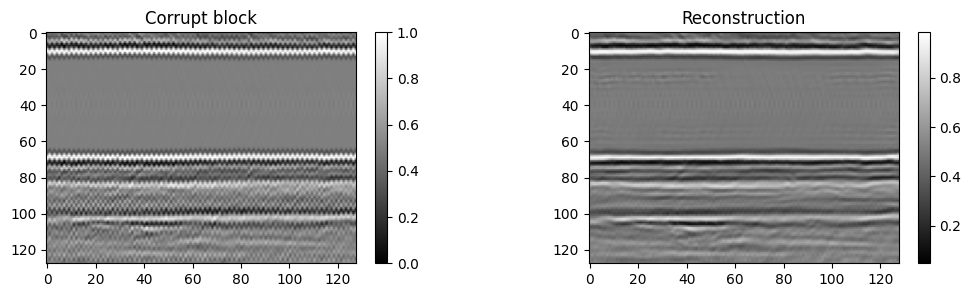

In [14]:
kk =90
plt.figure(figsize=(12,3))
plt.subplot(121)
plt.imshow(subblcks_corrupt[kk,:,:,0],aspect='auto',cmap='gray'), #plt.clim([0.5,0.64])
plt.colorbar()

plt.title("Corrupt block")

plt.subplot(122)
plt.imshow(recov_blcks[kk,:,:,0],aspect='auto',cmap='gray'), 
plt.colorbar()
plt.title("Reconstruction")


plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.show()

In [15]:
del denoised_tensor_list

**Poststack seismic data reassembly**

In [16]:
Urec  = recov_blcks.squeeze().transpose(1,2,0)
Urec = Urec.reshape(np.product(blksz), -1)

In [17]:
start = timeit.default_timer()
#imgd_median = array.average_blocks(Urec.reshape(blksz + (-1,)), singleffid.shape, stpsz)
imgd_median = array.combine_blocks(Urec.reshape(blksz + (-1,)), singleffid.shape, stpsz, np.median)
print("creating image from patching, time is:",
              timeit.default_timer() - start)

creating image from patching, time is: 15.542960699999998


In [18]:
med =imgd_median
med -=med.min()
med /=med.max()

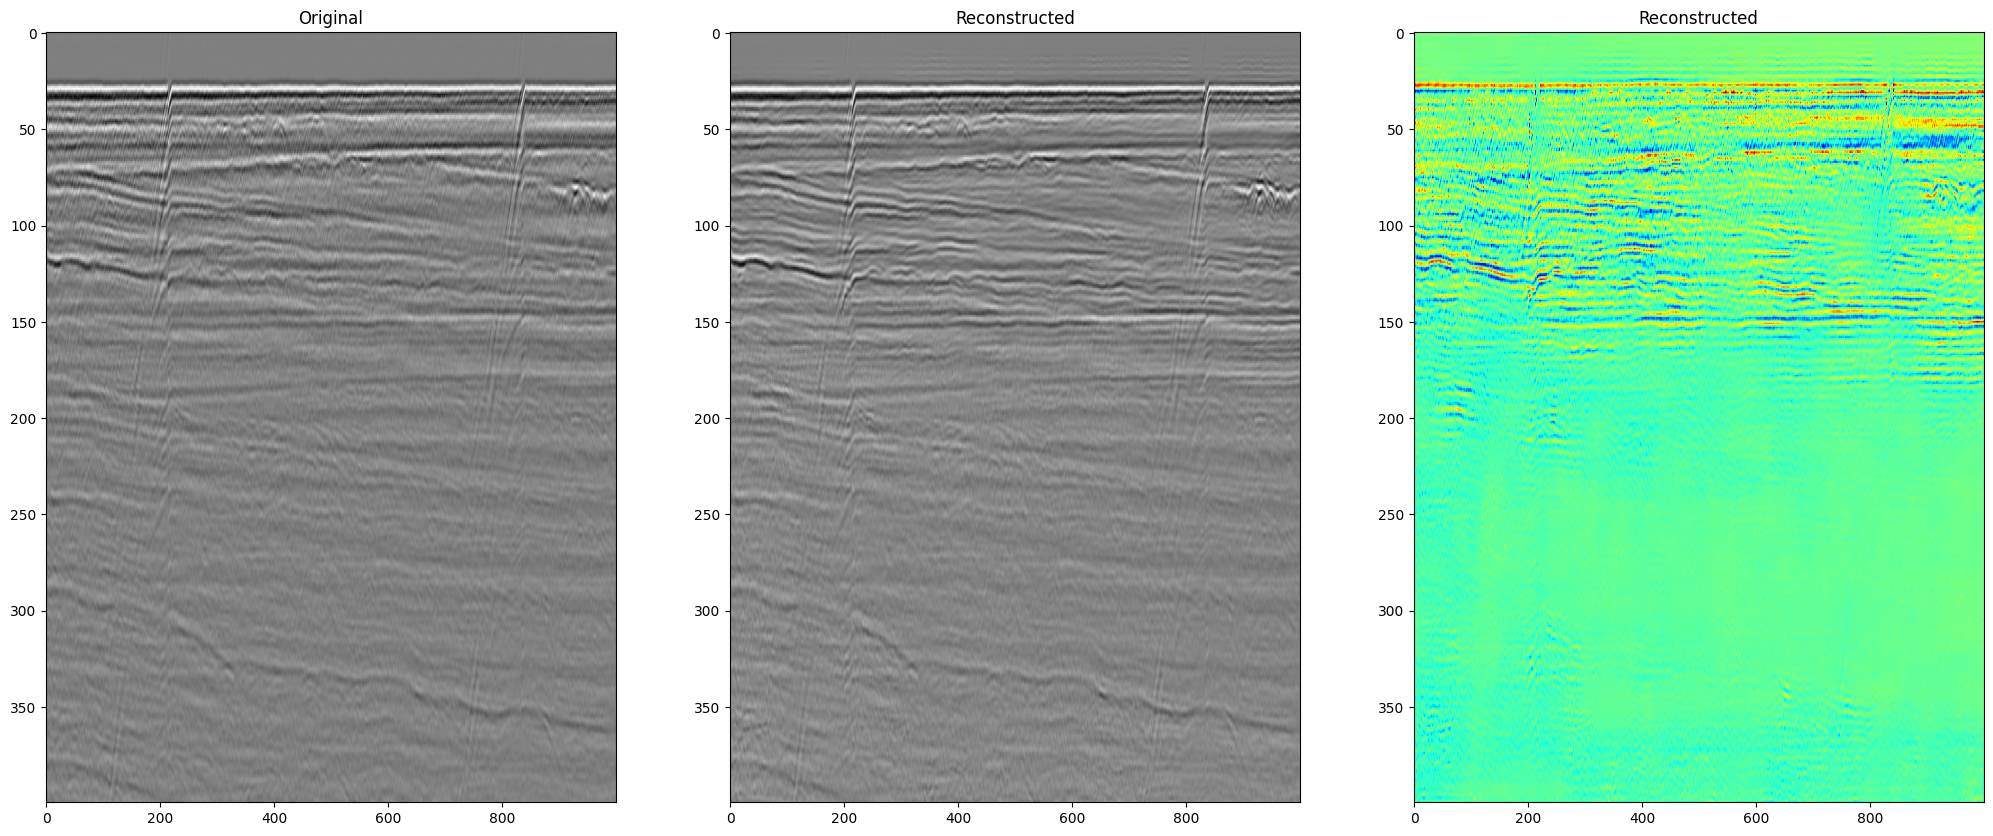

In [19]:
plt.figure(figsize=(25,10))

err = original-imgd_median[top:imgd_median.shape[0]-bot,lf:imgd_median.shape[1]-rt]
#err /= np.max(np.abs(err))

plt.subplot(131)
plt.imshow(original,cmap='gray', aspect='auto')
plt.title('Original')
plt.clim([0,1])
plt.subplot(132)
plt.imshow(med[top:imgd_median.shape[0]-bot,lf:imgd_median.shape[1]-rt],cmap='gray',aspect='auto'), plt.clim([0,1])
plt.title('Reconstructed')
plt.subplot(133)
plt.imshow(err,cmap='jet',aspect='auto', vmin=-0.2, vmax=0.2)
plt.title('Reconstructed')
plt.savefig('good.svg', bbox_inches="tight")
plt.show()

**Sections of the complete 2D enhancemet**

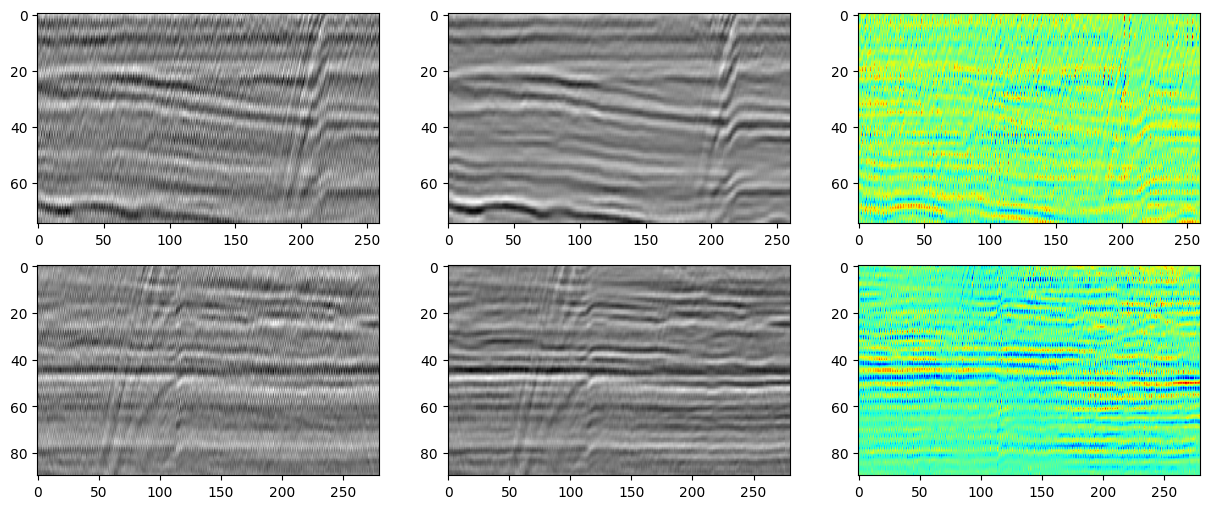

In [20]:
plt.figure(figsize=(15,6))
plt.subplot(231)
plt.imshow(original[50:125,:260], aspect="auto", cmap='gray')
plt.subplot(232)
plt.imshow(med[top:imgd_median.shape[0]-bot,lf:imgd_median.shape[1]-rt][50:125,:260], aspect="auto", cmap='gray')
plt.subplot(233)
plt.imshow(err[50:125,:260], aspect="auto", cmap='jet')
plt.subplot(234)
plt.imshow(original[100:190,720:], aspect="auto", cmap='gray')
plt.subplot(235)
plt.imshow(med[top:imgd_median.shape[0]-bot,lf:imgd_median.shape[1]-rt][100:190,720:], aspect="auto", cmap='gray')

plt.subplot(236)
plt.imshow(err[100:190,720:], aspect="auto", cmap='jet')
plt.show()

**Fast variance noise stimation**

In [21]:
import math
def estimate_noise(I):

  H, W = I.shape

  M = [[1, -2, 1],
       [-2, 4, -2],
       [1, -2, 1]]
  I= torch.from_numpy(I).float()
  M=np.array(M)
  M=torch.from_numpy(M).float()
  imgFiltered = F.conv2d(I.unsqueeze(0).unsqueeze(0), M.unsqueeze(0).unsqueeze(0), padding=1)
  x=imgFiltered.numpy()
  sigma = np.sum(np.sum(np.absolute(x)))
  sigma = sigma * math.sqrt(0.5 * math.pi) / (6 * (W-2) * (H-2))

  return sigma
print("Noisy image:",estimate_noise(TestData))
print("Denoised image:",estimate_noise(imgd_median))

Noisy image: 0.027313181782281024
Denoised image: 0.005204762274759302
